# !pip install openturns
https://openturns.github.io/openturns/latest/install.html


    Multivariate probabilistic modeling including dependence
    Numerical tools dedicated to the treatment of uncertainties
    Generic coupling to any type of physical model
    Open source, LGPL licensed, C++/Python library


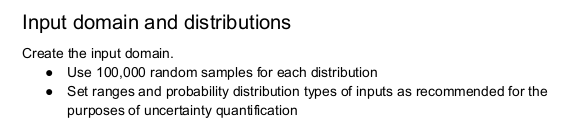

Input domain and distributions

Borehole Function

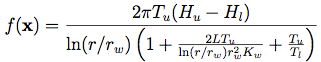

Description:
Dimensions: 8

The Borehole function models water flow through a borehole. Its simplicity and quick evaluation makes it 
a commonly used function for testing a wide variety of methods in computer experiments.

The response is water flow rate, in m3/yr.

Input Domain and Distributions:
The input variables and their usual input ranges are: 

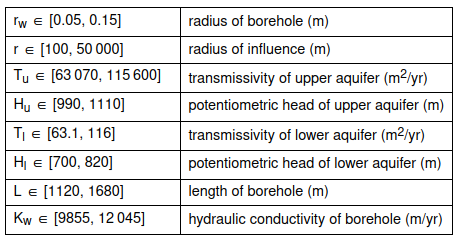

For the purposes of uncertainty quantification, the distributions of the input random variables are: 
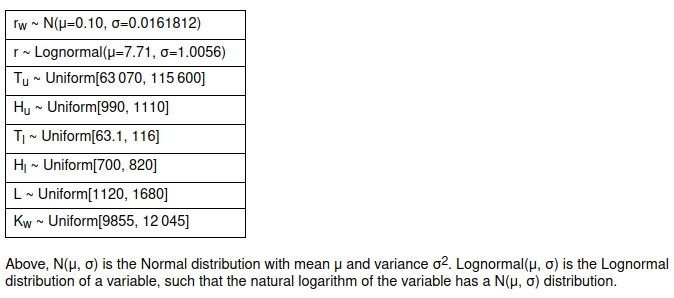

In this example we are going to compute global sensitivity indices from a functional chaos decomposition.

We study the Borehole function that models water flow through a borehole:

\begin{align}\frac{2 \pi T_u (H_u - H_l)}{\ln{r/r_w}(1+\frac{2 L T_u}{\ln(r/r_w) r^2_w K_w}\frac{T_u}{T_l})}\end{align}

With parameters:

- $r_w$: radius of borehole (m)
- $r$: radius of influence (m)
- $T_u$: transmissivity of upper aquifer ($m^2/yr$)
- $H_u$: potentiometric head of upper aquifer (m)
- $T_l$: transmissivity of lower aquifer ($m^2/yr$)
- $H_l$: potentiometric head of lower aquifer (m)
- $L$: length of borehole (m)
- $K_w$: hydraulic conductivity of borehole ($m/yr$)



In [150]:
import math
import openturns as ot
import openturns.viewer as otv
import openturns.viewer as viewer
import pandas as pd
import borehole_function
from operator import itemgetter
from matplotlib import pylab as plt
ot.Log.Show(ot.Log.NONE)

In [2]:
dimension = 8
input_names = ["rw", "r", "Tu", "Hu", "Tl", "Hl", "L", "Kw"]
model = ot.SymbolicFunction(
    input_names, ["(2*pi_*Tu*(Hu-Hl))/(ln(r/rw)*(1+(2*L*Tu)/(ln(r/rw)*rw^2*Kw)+Tu/Tl))"]
)
coll = [
    ot.Normal(0.1, 0.0161812),
    ot.LogNormal(7.71, 1.0056),
    ot.Uniform(63070.0, 115600.0),
    ot.Uniform(990.0, 1110.0),
    ot.Uniform(63.1, 116.0),
    ot.Uniform(700.0, 820.0),
    ot.Uniform(1120.0, 1680.0),
    ot.Uniform(9855.0, 12045.0),
]
distribution = ot.ComposedDistribution(coll)
distribution.setDescription(input_names)

## Draw the function



Create a training sample



In [30]:
sampleSize = 100000 #this only for check
inputSample = distribution.getSample(sampleSize)
outputSample = model(inputSample)

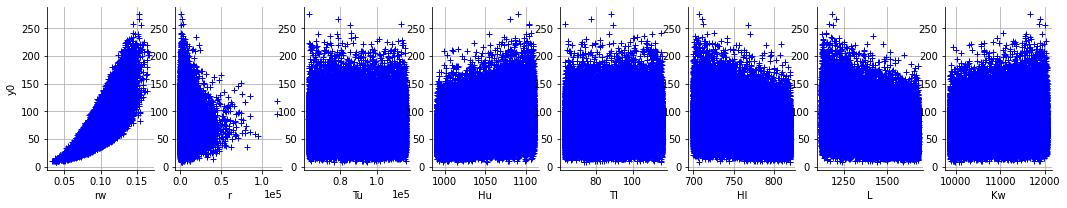

In [31]:
def plotXvsY(sampleX, sampleY):
    dimX = sampleX.getDimension()
    dimY = sampleY.getDimension()
    descriptionX = sampleX.getDescription()
    descriptionY = sampleY.getDescription()
    grid = ot.GridLayout(dimY, dimX)
    for i in range(dimY):
        for j in range(dimX):
            graph = ot.Graph("", descriptionX[j], descriptionY[i], True, "")
            cloud = ot.Cloud(sampleX[:, j], sampleY[:, i])
            graph.add(cloud)
            if j == 0:
                graph.setYTitle(descriptionY[i])
            else:
                graph.setYTitle("")
            if i == dimY - 1:
                graph.setXTitle(descriptionX[j])
            else:
                graph.setXTitle("")
            grid.setGraph(i, j, graph)
    return grid


grid = plotXvsY(inputSample, outputSample)
view = otv.View(grid, figure_kw={"figsize": (18.0, 3.0)})

In [152]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

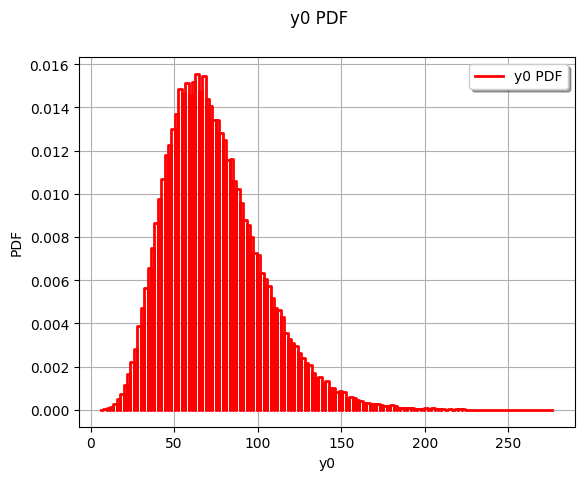

In [153]:
graph = ot.HistogramFactory().build(outputSample).drawPDF()
view = otv.View(graph)

We see that the distribution of the output has one mode.



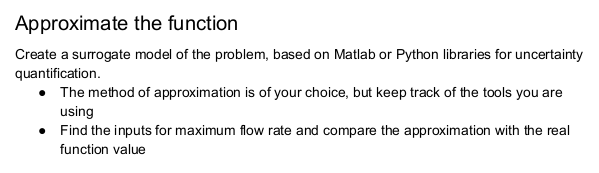

## Create the polynomial chaos model



Create a training sample



borehole model



In [6]:
im = borehole_function.BoreholeModel()

In [7]:
input_names = im.distributionX.getDescription()

In [13]:
sampleSize = 100000
inputTrain = im.distributionX.getSample(sampleSize)
outputTrain = im.model(inputTrain)

In [14]:
# inputTrain

Create the chaos.

We could use only the input and output training samples: in this case, the distribution of the input sample is computed by selecting the distribution that has the best fit.



In [15]:
chaosalgo = ot.FunctionalChaosAlgorithm(inputTrain, outputTrain)

E20231015 11:56:00.445150 44312 trust_region_minimizer.cc:95] Terminating: Number of consecutive invalid steps more than Solver::Options::max_num_consecutive_invalid_steps: 5


Since the input distribution is known in our particular case, we instead create
the multivariate basis from the distribution.
We define the orthogonal basis used to expand the function.
We see that each input has the uniform distribution, which corresponds to the
Legendre polynomials.



In [17]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory([im.rw, im.r, im.Tu, im.Hu, im.Tl, im.Hl, im.L, im.Kw])
multivariateBasis

Index,Name,Distribution,Univariate polynomial
0,rw,Normal,HermiteFactory
1,r,LogNormal,AdaptiveStieltjesAlgorithm
2,Tu,Uniform,LegendreFactory
3,Hu,Uniform,LegendreFactory
4,Tl,Uniform,LegendreFactory
5,Hl,Uniform,LegendreFactory
6,L,Uniform,LegendreFactory
7,Kw,Uniform,LegendreFactory


Then we create the sparse polynomial chaos expansion using regression and
the LARS selection model method.



In [18]:
selectionAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()
projectionStrategy = ot.LeastSquaresStrategy(selectionAlgorithm)
totalDegree = 8
enumerateFunction = multivariateBasis.getEnumerateFunction()
basisSize = enumerateFunction.getBasisSizeFromTotalDegree(totalDegree)
adaptiveStrategy = ot.FixedStrategy(multivariateBasis, basisSize)
chaosAlgo = ot.FunctionalChaosAlgorithm(
    inputTrain, outputTrain, im.distributionX, adaptiveStrategy, projectionStrategy
)

The coefficients of the polynomial expansion can then be estimated
using the :meth:`~openturns.FunctionalChaosAlgorithm.run` method.



In [19]:
chaosAlgo.run()

The :meth:`~openturns.FunctionalChaosAlgorithm.getResult` method returns the
result.



In [20]:
chaosResult = chaosAlgo.getResult()

In [21]:
chaosAlgo.getAdaptiveStrategy()

class=AdaptiveStrategy implementation=class=FixedStrategy derived from class=AdaptiveStrategyImplementation maximumDimension=12870

The polynomial chaos result provides a pretty-print.



In [22]:
# ot.getMaximumFunctionEvaluation()

In [23]:
chaosResult
# .getMaximumFunctionEvaluation()

Index,Multi-index,Coeff.
0,"[0,0,0,0,0,0,0,0]",73.73886
1,"[1,0,0,0,0,0,0,0]",23.15039
2,"[0,1,0,0,0,0,0,0]",-0.02989747
3,"[0,0,0,1,0,0,0,0]",8.808264
4,"[0,0,0,0,1,0,0,0]",0.06644848
5,"[0,0,0,0,0,1,0,0]",-8.808143
6,"[0,0,0,0,0,0,1,0]",-8.563101
7,"[0,0,0,0,0,0,0,1]",4.235437
8,"[2,0,0,0,0,0,0,0]",2.60359
9,"[1,1,0,0,0,0,0,0]",-0.01795835


Get the metamodel.



In [25]:
metamodel = chaosResult.getMetaModel()

In order to validate the metamodel, we generate a test sample.



In [26]:
n_valid = 100000
inputTest = im.distributionX.getSample(n_valid)
outputTest = im.model(inputTest)
val = ot.MetaModelValidation(inputTest, outputTest, metamodel)
Q2 = val.computePredictivityFactor()[0]
Q2

0.9999986336767184

In [27]:
inputTest

class=Sample name=ComposedDistribution implementation=class=SampleImplementation name=ComposedDistribution size=100000 dimension=8 description=[rw,r,Tu,...,Hl,L,Kw] data=[[0.112499,2565.37,115370,...,791.617,1667.55,10014.4],[0.0823958,578.322,76238.5,...,755.819,1500.03,10381.7],[0.0822033,363.653,86266,...,766.312,1603.16,10930.4],...,[0.117962,1291.06,84480.5,...,807.241,1265.44,10653.7],[0.125886,1005.29,90081.4,...,779.984,1302,11263.5],[0.129045,1490.93,80535.7,...,795.072,1311.19,10568.1]]

The Q2 is very close to 1: the metamodel is excellent.



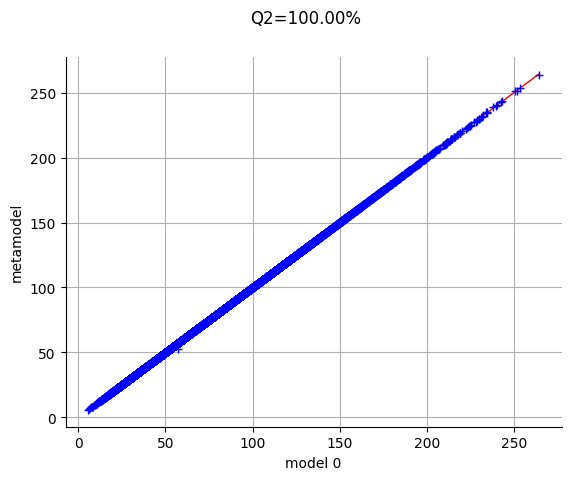

In [154]:
graph = val.drawValidation()
graph.setTitle("Q2=%.2f%%" % (Q2 * 100))
view = otv.View(graph)

The metamodel has a good predictivity, since the points are almost on the first diagonal.



Text(0, 0.5, 'y0, Flow reate')

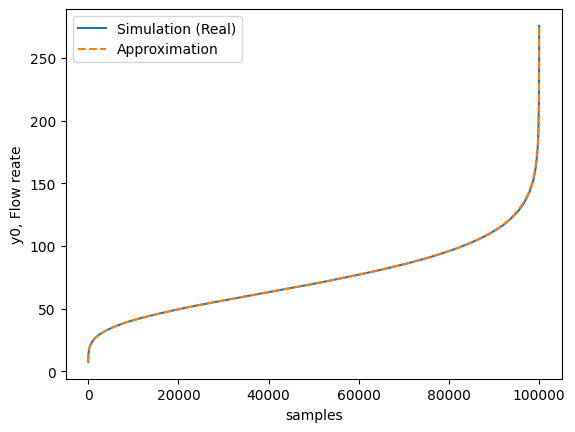

In [159]:
plt.plot(outputSample.sort(), label='Simulation (Real)')
plt.plot(chaosResult.getOutputSample().sort(), label='Approximation',linestyle='dashed')
plt.legend()
plt.xlabel("samples")
plt.ylabel("y0, Flow reate")

In [34]:
iterExtrema = ot.IterativeExtrema(1)

In [35]:
minEvolution = ot.Sample()
maxEvolution = ot.Sample()
for i in range(sampleSize):
    point = outputSample
    iterExtrema.increment(point)
    minEvolution.add(iterExtrema.getMin())
    maxEvolution.add(iterExtrema.getMax())

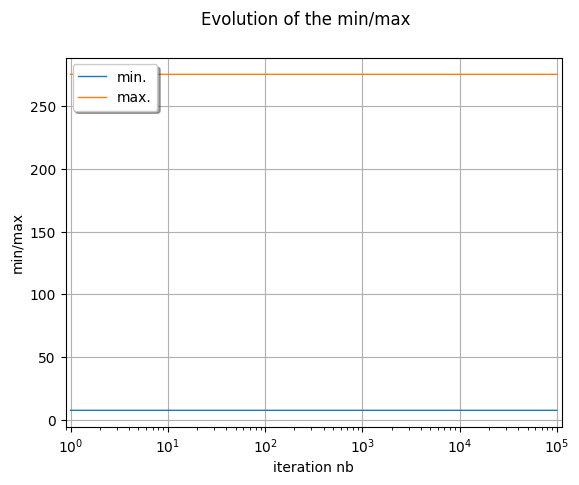

In [160]:
iterationSample = ot.Sample.BuildFromPoint(range(1, sampleSize + 1))
palette = ot.Drawable().BuildDefaultPalette(2)
#
curveMin = ot.Curve(iterationSample, minEvolution)
curveMin.setColor(palette[0])
curveMin.setLegend("min.")
#
curveMax = ot.Curve(iterationSample, maxEvolution)
curveMax.setColor(palette[1])
curveMax.setLegend("max.")
#
graph = ot.Graph("Evolution of the min/max", "iteration nb", "min/max", True)
graph.add(curveMin)
graph.add(curveMax)
graph.setLegendPosition("topleft")
graph.setLogScale(ot.GraphImplementation.LOGX)
view = otv.View(graph)

In [37]:
samples = outputSample
iterExtrema.increment(samples)

In [45]:
print("Total number of iterations: " + str(iterExtrema.getIterationNumber()))
print("Minimum: ", iterExtrema.getMin())
print("Maximum: ", iterExtrema.getMax())

otv.View.ShowAll()

Total number of iterations: 10000100000
Minimum:  [7.5049]
Maximum:  [275.426]


In [46]:
outputSample.getMax()

class=Point name=Unnamed dimension=1 values=[275.426]

In [140]:
def find_best_parameters(input_data, output_data):
    in_data = input_data.asDataFrame()
    out_data = output_data.asDataFrame()
    max_out= out_data.idxmax().values
    best_in=in_data.iloc[max_out]
    result_best=pd.DataFrame()
    result_best['Name']='best'
    result_best['MaxFlow']= out_data.max().values
    result_best[list(best_in.columns)]=best_in.values
    result_best=result_best.set_index('Name')
    final= result_best.to_dict()
    print(result_best.T)
    

RESULT. Inputs for maximum flow rate

Real function value

In [141]:
find_best_parameters(inputSample, outputSample)

Name              NaN
MaxFlow    275.425716
rw           0.152943
r         1206.141038
Tu       63597.233101
Hu        1090.697320
Tl          87.940941
Hl         706.931903
L         1181.522061
Kw       11675.276807


Approximation

In [142]:
find_best_parameters(chaosResult.getInputSample(), chaosResult.getOutputSample())

Name              NaN
MaxFlow    274.034480
rw           0.153822
r         7911.074757
Tu       85758.116725
Hu        1093.239623
Tl         112.110568
Hl         721.903150
L         1126.211569
Kw       11309.409130


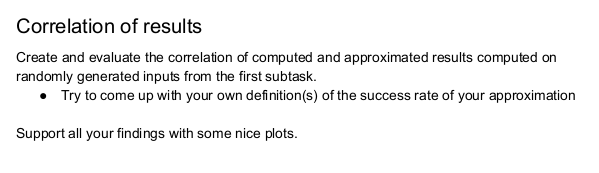

## Compute mean and variance



The mean and variance of a polynomial chaos expansion are computed
using the coefficients of the expansion.
This can be done using :class:`~openturns.FunctionalChaosRandomVector`.



In [161]:
import math

In [162]:
randomVector = ot.FunctionalChaosRandomVector(chaosResult)
mean = randomVector.getMean()
print("Mean=", mean)
covarianceMatrix = randomVector.getCovariance()
print("Covariance=", covarianceMatrix)
outputDimension = outputTrain.getDimension()
stdDev = ot.Point(outputDimension)
for i in range(outputDimension):
    stdDev[i] = math.sqrt(covarianceMatrix[i, i])
print("Standard deviation=", stdDev)

Mean= [73.7389]
Covariance= [[ 817.712 ]]
Standard deviation= [28.5957]


In [163]:
# surrogate 

## Compute and print Sobol' indices



By default, printing the object will print the Sobol' indices
and the multi-indices ordered by decreasing part of variance.
If a multi-index has a part of variance which is lower
than some threshold, it is not printed.
This threshold can be customized using the
`FunctionalChaosSobolIndices-VariancePartThreshold` key of the
:class:`~openturns.ResourceMap`.



In [171]:
chaosSI = ot.FunctionalChaosSobolIndices(chaosResult)
chaosSI

class=FunctionalChaosSobolIndices functional chaos result=class=FunctionalChaosResult derived from  metaModel=class=Function name=Unnamed implementation=class=ComposedFunction name=Unnamed description=[rw,r,Tu,Hu,Tl,Hl,L,Kw,y] left function=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,x4,x5,x6,x7,v0] evaluationImplementation=class=DualLinearCombinationEvaluation functions=[class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,x4,x5,x6,x7,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,x4,x5,x6,x7,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=2 values=[0,1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,x4,x5,x6,x7,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=2 values=[-0.756148,0.000204461],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,x4,x5,x6,x7,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=2 valu

In [165]:
myFittedDist = ot.GeneralizedParetoFactory().buildAsGeneralizedPareto()
print(myFittedDist)

GeneralizedPareto(sigma = 1, xi=0, u=0)


In [166]:
chaosResult.getResiduals()

class=Point name=Unnamed dimension=1 values=[9.49608e-05]

We notice the a coefficient with marginal degree equal to 1 has a significant impact on the output variance. Hence, we cannot get a satisfactory polynomial chaos with total degree less that 1.



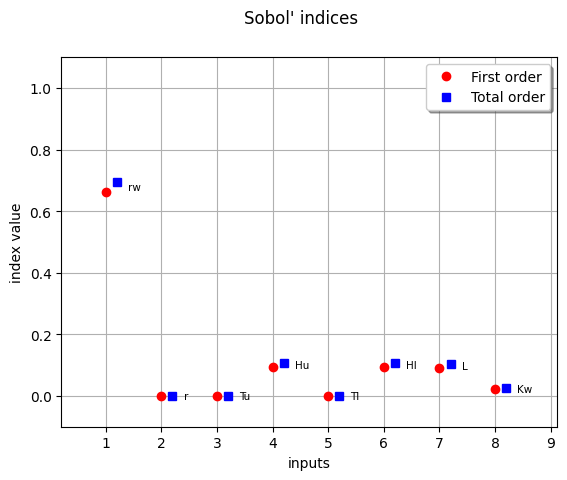

In [167]:
dim_input = im.distributionX.getDimension()
first_order = [chaosSI.getSobolIndex(i) for i in range(dim_input)]
total_order = [chaosSI.getSobolTotalIndex(i) for i in range(dim_input)]
input_names = im.model.getInputDescription()
graph = ot.SobolIndicesAlgorithm.DrawSobolIndices(input_names, first_order, total_order)
view = otv.View(graph)

In [168]:
S_exact = [im.rw, im.r, im.Tu, im.Hu, im.Tl, im.Hl, im.L, im.Kw]
# ST_exact = [im.ST1, im.ST2, im.ST3]

We saw that total order indices are close to first order, so the higher order indices must be all quite close to 0

draw Sobol' indices



In [173]:
import openturns as ot
from operator import itemgetter
import openturns.viewer as viewer
from matplotlib import pylab as plt

ot.Log.Show(ot.Log.NONE)


# Sobol' sensitivity indices from chaos


In [181]:
dimension = 8
input_names = ["rw", "r", "Tu", "Hu", "Tl", "Hl", "L", "Kw"]
model = ot.SymbolicFunction(
    input_names, ["(2*pi_*Tu*(Hu-Hl))/(ln(r/rw)*(1+(2*L*Tu)/(ln(r/rw)*rw^2*Kw)+Tu/Tl))"]
)
coll = [
    ot.Normal(0.1, 0.0161812),
    ot.LogNormal(7.71, 1.0056),
    ot.Uniform(63070.0, 115600.0),
    ot.Uniform(990.0, 1110.0),
    ot.Uniform(63.1, 116.0),
    ot.Uniform(700.0, 820.0),
    ot.Uniform(1120.0, 1680.0),
    ot.Uniform(9855.0, 12045.0),
]
distribution = ot.ComposedDistribution(coll)
distribution.setDescription(input_names)

In [175]:
selection = [1, 2, 4]
complement = ot.Indices(selection).complement(dimension)
distribution = distribution.getMarginal(complement)
model = ot.ParametricFunction(
    model, selection, distribution.getMarginal(selection).getMean()
)
input_names_copy = list(input_names)
input_names = itemgetter(*complement)(input_names)
dimension = len(complement)

In [182]:
size = 100000
X = distribution.getSample(size)
Y = model(X)

In [183]:
algo = ot.FunctionalChaosAlgorithm(X, Y)
algo.run()
result = algo.getResult()
print(result.getResiduals())
print(result.getRelativeErrors())

[0.000400212]
[1.95095e-05]


E20231015 12:59:11.344085 44312 trust_region_minimizer.cc:95] Terminating: Number of consecutive invalid steps more than Solver::Options::max_num_consecutive_invalid_steps: 5


Quick summary of sensitivity analysis

In [184]:
sensitivityAnalysis = ot.FunctionalChaosSobolIndices(result)
print(sensitivityAnalysis)

FunctionalChaosSobolIndices
- input dimension=8
- output dimension=1
- basis size=473
- mean=[73.5548]
- std-dev=[2263.88]

| Index | Multi-index   | Variance part |
|-------|---------------|---------------|
|   346 | [0,9,0,0,0,0,0,0]| 0.150948      |
|   296 | [1,4,0,0,0,0,0,0]| 0.120692      |
|   148 | [1,3,0,0,0,0,0,0]| 0.0830266     |
|   134 | [0,7,0,0,0,0,0,0]| 0.0735884     |
|    18 | [0,3,0,0,0,0,0,0]| 0.0722439     |
|   301 | [0,4,0,0,0,0,1,0]| 0.0576473     |
|   298 | [0,4,0,1,0,0,0,0]| 0.0490367     |
|   126 | [0,6,0,0,0,0,0,0]| 0.0445697     |
|    54 | [0,4,0,0,0,0,0,0]| 0.0428903     |
|   297 | [0,4,1,0,0,0,0,0]| 0.042366      |
|   153 | [0,3,0,0,0,0,1,0]| 0.0401939     |
|   150 | [0,3,0,1,0,0,0,0]| 0.0336765     |
|   149 | [0,3,1,0,0,0,0,0]| 0.029669      |
|   410 | [0,10,0,0,0,0,0,0]| 0.0293984     |
|    10 | [0,2,0,0,0,0,0,0]| 0.0259147     |
|   299 | [0,4,0,0,1,0,0,0]| 0.0184013     |
|   300 | [0,4,0,0,0,1,0,0]| 0.0178036     |
|   151 | [0,3,0,0,1,0,0,0

In [185]:
for i in range(dimension):
    for j in range(i):
        print(
            input_names[i] + " & " + input_names[j],
            ":",
            sensitivityAnalysis.getSobolIndex([i, j]),
        )

plt.show()

r & rw : 0.21677860417901482
Tu & rw : 1.8228016307466635e-10
Tu & r : 0.07657896022852025
Hu & rw : 1.5169438481384031e-06
Hu & r : 0.08802492133216443
Hu & Tu : 8.171895827827099e-11
Tl & rw : 4.2481112824855065e-10
Tl & r : 0.03332319490955157
Tl & Tu : 2.259438118324681e-13
Tl & Hu : 1.7935541493771524e-11
Hl & rw : 1.504294153185387e-06
Hl & r : 0.031868251905376836
Hl & Tu : 1.8954275347920953e-11
Hl & Hu : 1.881720070677746e-11
Hl & Tl : 1.9358876713678358e-11
L & rw : 1.4504822123863078e-06
L & r : 0.10403592181556959
L & Tu : 2.029499083098016e-11
L & Hu : 2.0651777905117825e-07
L & Tl : 6.066751268393461e-11
L & Hl : 2.0514520254716213e-07
Kw & rw : 3.5082499593823074e-07
Kw & r : 0.009097955239977053
Kw & Tu : 7.199347585762949e-12
Kw & Hu : 4.963042806285818e-08
Kw & Tl : 1.7746591414674785e-11
Kw & Hl : 4.9414738382004e-08
Kw & L : 4.7255017113454165e-08


In [8]:
# dist1 = ot.computeConditionalDDF(outputSample, inputSample)

Polynomial chaos expansions (PCE) are well-suited to quantifying uncertainty in models parameterized by independent random variables.The assumption of independence leads to simple strategies for building multivariate orthonormal bases and for sampling strategies.
to evaluate PCE coefficients. In contrast, the application of PCE to models of dependent variables is much more challenging. Three
Approaches can be used to construct PCE models of dependent variables.
In my particular case, the approximation using surrogate modeling shows different sensitivity to input parameters as I have not used a large number of samples.
according to the RAM limit on my PC. However, in general, the proposed method shows a very relevant result.
After running the experiment on a PC with 64 GB of RAM, the task was well performed, and the result of the estimation was improved as well as sensetivity analisys.
By summurirized PCE methode shows good result and already activily used in ucertenty quantificaion.  
 In addition, the algorithm can reduce the total number of required PCE terms to approximate the model output by combining several parametric uncertainties into a similarity parameter. To solve the PCE coefficients of model predictions quickly, the gDRM can be used to approximate each high-dimensional integral from the inner product of the spectral projection with several lower-dimensional ones. To show the efficiency of the algorithm, engineering examples were used. The results show the approach in this work can significantly reduce the computational cost, while maintaining the UQ accuracy.